In [7]:
!pip install imutils

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import random
import warnings
warnings.filterwarnings("ignore")

Data load

In [9]:
print('Image(Train):',len(os.listdir('data/training_images')))
print('Image(Test):',len(os.listdir('data/testing_images')))

Image(Train): 1001
Image(Test): 175


In [10]:
Data=pd.read_csv('data/train_solution_bounding_boxes (1).csv')

In [11]:
Data.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [12]:
print('Train data localization:',len(Data))

Train data localization: 559


Photo shape: (380, 676, 3)
Name,xmin,ymin,xmax,ymax: ['vid_4_1000.jpg' 281.2590449 187.0350708 327.7279305 223.225547]


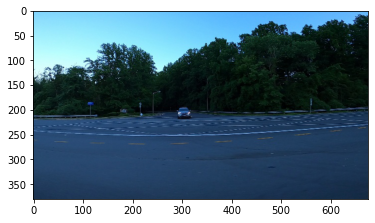

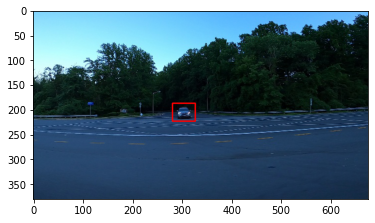

In [13]:
for i in Data.values:
  photo=plt.imread(f'data/training_images/{i[0]}')
  plt.imshow(photo)
  print('Photo shape:',photo.shape)
  print('Name,xmin,ymin,xmax,ymax:',i)
  pt1=(int(i[1]),int(i[2]))
  pt2=(int(i[3]),int(i[4]))
  color=(255, 0, 0)
  thickness = 2
  cv2.rectangle(photo,pt1,pt2, color, thickness)
  plt.figure()
  plt.imshow(photo)
  break


Annotations (Check)

(380, 676, 3)
(380, 676, 3)
(380, 676, 3)


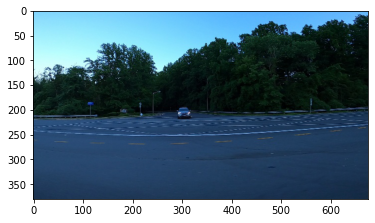

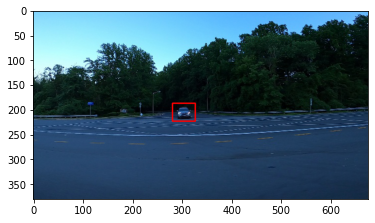

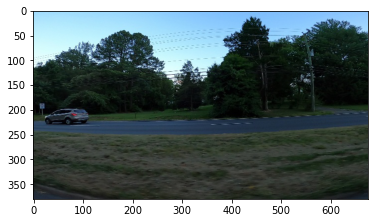

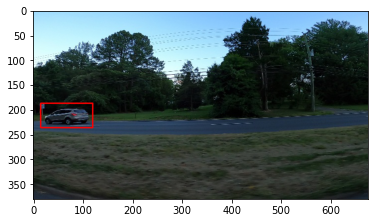

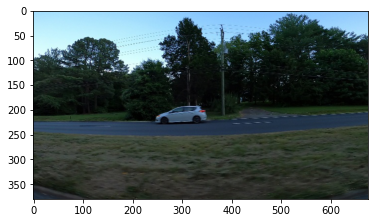

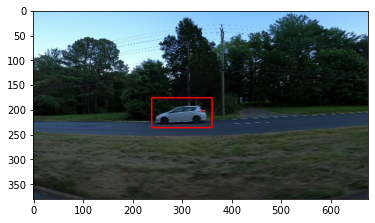

In [14]:
for a,i in enumerate(Data.values):
  img=plt.imread('data/training_images/'+i[0])
  print(img.shape)
  plt.figure()
  plt.imshow(img)
  xmin=int(i[1])
  ymin=int(i[2])
  xmax=int(i[3])
  ymax=int(i[4])
  cv2.rectangle(img,(xmin, ymin),(xmax, ymax),(255, 0, 0),2)
  plt.figure()
  plt.imshow(img)
  if a ==2:
    break

Selective Search kullanimi

In [15]:
cv2.setUseOptimized(True) # Optimeze
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() # Selective search obje

Shape: (224, 224, 3)
possible bounty boxes: 210


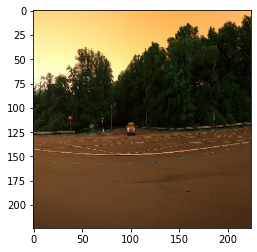

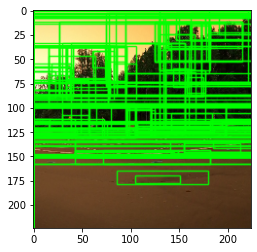

In [16]:
im = cv2.imread('data/training_images/vid_4_1000.jpg')
im=cv2.resize(im,(224,224))
plt.figure()
plt.imshow(im)
ss.setBaseImage(im) # Image section is loaded
ss.switchToSelectiveSearchFast() # To speed up selective search time
rects = ss.process()
print('Shape:',im.shape)
print('possible bounty boxes:',len(rects))

for rect in rects:
  x, y, w, h = rect
  imOut=cv2.rectangle(im, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure()
plt.imshow(imOut);

Selective search crop the image iou > 0.5 (Kullanimi)

Selective search

In [17]:
#Iou and selective search 
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
def get_iou(bb1, bb2):

    assert bb1['x1'] < bb1['x2'] #bb1
    assert bb1['y1'] < bb1['y2']

    assert bb2['x1'] < bb2['x2'] #bb2
    assert bb2['y1'] < bb2['y2'];

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
      return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [18]:
image_liste=[]
k=0
l=0
z=0 #Loading
for a in pd.read_csv('data/train_solution_bounding_boxes (1).csv').values:
  Name,xmin,ymin,xmax,ymax=a
  bb1={ #gerçek bounty boxxes
            'x1':int(xmin),
            'y1':int(ymin),
            'x2':int(xmax),
            'y2':int(ymax)
            }
  try:
    img=cv2.imread('data/training_images/'+Name)
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    for i in rects:
      x, y, w, h = i # Selective bounty boxxes
      bb2={'x1':x, 
          'y1':y,
          'x2':x+w,
          'y2':y+h
          }
      img1=img[bb2['y1']:bb2['y2'],bb2['x1']:bb2['x2']] # Crop img
      img1_shape=cv2.resize(img1,(224,224))
      if k<l:
            if 0.5<get_iou(bb1,bb2):  
              image_liste.append([img1_shape,1])
              k+=1
      else:
        if 0.5<get_iou(bb1,bb2):  
          image_liste.append([img1_shape,1])
          k+=1
        else:
          image_liste.append([img1_shape,0])
          l+=1
  except Exception as e:
    print('hata var',e)
  z+=1
  print(Name,z,len(rects))

vid_4_1000.jpg 1 1138
vid_4_10000.jpg 2 1426
vid_4_10040.jpg 3 1446
vid_4_10020.jpg 4 1402
vid_4_10060.jpg 5 1475
vid_4_10100.jpg 6 1712
vid_4_10120.jpg 7 1529
vid_4_10140.jpg 8 1627
vid_4_1020.jpg 9 1120
vid_4_1040.jpg 10 1219
vid_4_10480.jpg 11 1714
vid_4_10500.jpg 12 1771
vid_4_10520.jpg 13 1724
vid_4_1060.jpg 14 1330
vid_4_10960.jpg 15 1865
vid_4_10980.jpg 16 1816
vid_4_11000.jpg 17 1776
vid_4_11020.jpg 18 1657
vid_4_11240.jpg 19 1725
vid_4_11260.jpg 20 1912
vid_4_11280.jpg 21 1971
vid_4_11380.jpg 22 1779
vid_4_11400.jpg 23 1859
vid_4_11420.jpg 24 1904
vid_4_11440.jpg 25 1842
vid_4_11900.jpg 26 1973
vid_4_11880.jpg 27 1881
vid_4_11920.jpg 28 1935
vid_4_11940.jpg 29 1917
vid_4_11960.jpg 30 2033
vid_4_11980.jpg 31 2081
vid_4_12000.jpg 32 1849
vid_4_12040.jpg 33 2052
vid_4_12100.jpg 34 1917
vid_4_12060.jpg 35 2009
vid_4_12080.jpg 36 2034
vid_4_12120.jpg 37 1874
vid_4_12140.jpg 38 1671
vid_4_12140.jpg 39 1671
vid_4_12160.jpg 40 1697
vid_4_12160.jpg 41 1697
vid_4_12160.jpg 42 1697
vid_4

In [20]:
len(image_liste)

10599

In [21]:
data=[]
data_label=[]
for features,label in image_liste:
  data.append(features)
  data_label.append(label)
print('successed')

successed


In [23]:
print('Number of photos:',len(data),'|Label of photos:',len(data_label))

Number of photos: 10599 |Label of photos: 10599


Class: 0
Image size: (224, 224, 3)


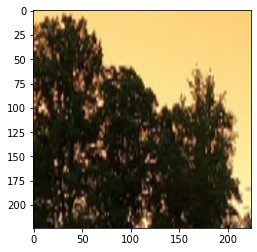

In [24]:
i=random.randint(1,10583)
print('Class:',data_label[i])
print('Image size:',data[i].shape)
plt.imshow(data[i]);

In [25]:
data=np.asarray(data)
data_label=np.asarray(data_label) 

In [26]:
print('No car pictures:',len(data_label[data_label==0]),'|Car pictures:',len(data_label[data_label==1]))

No car pictures: 5300 |Car pictures: 5299


In [27]:
data.shape

(10599, 224, 224, 3)

In [28]:
data_label.shape

(10599,)

In [29]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val=train_test_split(data,data_label,test_size=0.33, random_state=42)

In [30]:
print('x_train shape:',x_train.shape)
print('x_val shape:',x_val.shape)
print('y_train shape:',y_train.shape)
print('y_val shape:',y_val.shape)

x_train shape: (7101, 224, 224, 3)
x_val shape: (3498, 224, 224, 3)
y_train shape: (7101,)
y_val shape: (3498,)


In [31]:
base_model=tf.keras.applications.VGG16(include_top=False,input_shape=(224,224,3),weights='imagenet')

58892288/58889256 [==============================] - 13s 0us/step 


In [32]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [33]:
model=tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [34]:
base_model.trainable=False

In [35]:
for i,layer in enumerate(base_model.layers):
  print(i,layer.name,'-',layer.trainable)

0 input_1 - False
1 block1_conv1 - False
2 block1_conv2 - False
3 block1_pool - False
4 block2_conv1 - False
5 block2_conv2 - False
6 block2_pool - False
7 block3_conv1 - False
8 block3_conv2 - False
9 block3_conv3 - False
10 block3_pool - False
11 block4_conv1 - False
12 block4_conv2 - False
13 block4_conv3 - False
14 block4_pool - False
15 block5_conv1 - False
16 block5_conv2 - False
17 block5_conv3 - False
18 block5_pool - False


In [36]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics='accuracy')

In [37]:
epoch=4
hist=model.fit(x_train,y_train,epochs=epoch,validation_data=(x_val,y_val))

Epoch 1/4
222/222 [==============================] - 9159s 41s/step - loss: 0.7158 - accuracy: 0.8065 - val_loss: 0.1918 - val_accuracy: 0.9528
Epoch 2/4
222/222 [==============================] - 6006s 27s/step - loss: 0.2775 - accuracy: 0.9223 - val_loss: 0.1777 - val_accuracy: 0.9600
Epoch 3/4
222/222 [==============================] - 3702s 17s/step - loss: 0.2141 - accuracy: 0.9361 - val_loss: 0.1308 - val_accuracy: 0.9657
Epoch 4/4
222/222 [==============================] - 3760s 17s/step - loss: 0.1798 - accuracy: 0.9473 - val_loss: 0.1324 - val_accuracy: 0.9706


Number of possible objects in the photo:  2033
how many possible bounty boxes with a class prediction of 1 are there: 55
-------------------------------------------------------------------------


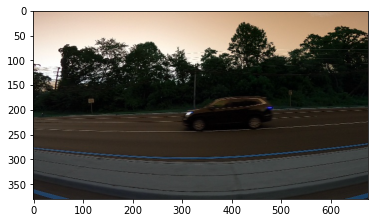

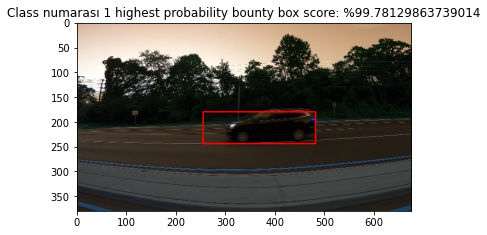

In [38]:
car=[]
photo_path='data/testing_images/vid_5_27620.jpg'
deneme_img=cv2.imread(photo_path)
ss.setBaseImage(deneme_img)
ss.switchToSelectiveSearchFast()
rects1 = ss.process()
print('Number of possible objects in the photo: ',len(rects1))
for i in rects1:
  x, y, w, h = i
  bb3={'x1':x,
        'y1':y,
        'x2':x+w,
        'y2':y+h
      }
  try:
    assert bb3['x1'] < bb3['x2']
    assert bb3['y1'] < bb3['y2']
    img_data=deneme_img[bb3['y1']:bb3['y2'],bb3['x1']:bb3['x2']]
    img_data=cv2.resize(img_data,(224,224))
    tahmin=model.predict(img_data.reshape(1,224,224,3))
    if tahmin[0]>0.5:
      car.append([bb3,tahmin[0]])
    else:
      pass
  except Exception as e:
    print('e: ',e)
print('how many possible bounty boxes with a class prediction of 1 are there:',len(car))
print('-------------------------------------------------------------------------')
deneme_img=cv2.imread(photo_path)
car[np.argmax(np.array(car)[:,1])][0]
pt1=(car[np.argmax(np.array(car)[:,1])][0]['x1'],car[np.argmax(np.array(car)[:,1])][0]['y1'])
pt2=(car[np.argmax(np.array(car)[:,1])][0]['x2'],car[np.argmax(np.array(car)[:,1])][0]['y2'])
plt.figure()
plt.imshow(deneme_img)
cv2.rectangle(deneme_img,pt1,pt2,(255, 0, 0),2)
plt.figure()
plt.title(f'Class numarası 1 highest probability bounty box score: %{car[np.argmax(np.array(car)[:,1])][1][0]*100}') 
plt.imshow(deneme_img);